In [1]:
from tensorflow.keras import models, layers, optimizers, callbacks, backend
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams['figure.dpi']=150
import time
import pickle
import sys

/Users/nicolas/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/nicolas/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file 

In [2]:
data1 = np.load("training/data/1OverF_1.npz")
c_data = data1['arr_0']       # C data
T_in = data1['arr_1']         # Time vector for data generation 
s_data = data1['arr_2']       # S data
w0 = data1['arr_3']           # Omega vector for data generation
T_train = data1['arr_4']      # Time vector for training data (based on the experimental data)
w_train = data1['arr_5']      # Omega vector for training data
T2_span = data1['arr_6']      # T2 distribution

In [3]:
# For data interpolation
def interpData(x,y,xNew):
    f_interp = interp1d(x,y)
    yNew = f_interp(xNew)
    return yNew

# For preparing training data: Add random noise, then replace low values with zeros
# Run this cell multiple times to generate sets with different random noise but same underlying curves
def prepare_trainData(c_in,T_in,T_train,noiseMax=0.03,cutOff=0.03):
    c_train = interpData(T_in,c_in,T_train)
    for i in range(c_in.shape[0]):
        c_train[i,:] = c_train[i,:] + np.random.normal(0,noiseMax*2/3,size=c_train.shape[1])
        cut = np.squeeze(np.argwhere(c_train[i,:]<=cutOff+np.random.normal(0,noiseMax*2/3,1)))
    if cut.size > 1:
        c_train[i,cut[0]-1:] = 0
    elif cut.size == 1:
        c_train[i,cut-1:] = 0
    return c_train

In [4]:
nnps = 6 #-- noise number per sample
# Interpolate, add random noise to experimental conditions, cut the tail of the data
c_train_1set = prepare_trainData( c_data, T_in, T_train )
s_train_1set = interpData( w0, s_data, w_train )
d1 = np.shape( c_train_1set )[0]
d2 = np.shape( c_train_1set )[1]
d3 = np.shape( s_train_1set )[1]
c_train = np.zeros( ( d1*nnps, d2 ) )
s_train = np.zeros( ( d1*nnps, d3 ) )
for i in range(nnps):
    c_train_1set = prepare_trainData( c_data, T_in, T_train, noiseMax=0.015,cutOff=0.03 )
    c_train[i*d1:(i+1)*d1,:] = c_train_1set
    s_train[i*d1:(i+1)*d1,:] = s_train_1set

X = c_train
y = s_train
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)    

print("x_train = ",np.shape(x_train))
print("y_train = ",np.shape(y_train))
print("x_test = ",np.shape(x_test))
print("y_test = ",np.shape(y_test))
print("w0 = ",np.shape(w0))
print("w_train = ",np.shape(w_train))

x_train =  (30064, 147)
y_train =  (30064, 501)
x_test =  (5306, 147)
y_test =  (5306, 501)
w0 =  (4001,)
w_train =  (501,)


In [7]:
def get_model( filter_nb, kernel_size, pool_size, dropout_rate ):
    model = models.Sequential()
    model.add( layers.Input( shape=(x_train.shape[-1], 1) ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//2, kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    
    model.add( layers.Conv1D( filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D( filter_nb//2,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D( filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    
    model.add( layers.Conv1D( filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Conv1D( 1, kernel_size, activation="relu", padding='same' ) )
    model.add( layers.Flatten() )
    model.add( layers.Dropout( dropout_rate ) )
    model.add( layers.Dense(501, activation='linear') )  
    
    return model 

In [8]:
BATCH_SIZE = 64
EPOCHS = 20
INIT_LR = 1e-5
MAX_LR = 1e-3

model = get_model( filter_nb=80, kernel_size=48, pool_size=2, dropout_rate=0.05 )
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 147, 80)           3920      
                                                                 
 conv1d_10 (Conv1D)          (None, 147, 80)           307280    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 74, 80)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 74, 40)            153640    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 37, 40)           0         
 1D)                                                             
                                                                 
 conv1d_12 (Conv1D)          (None, 37, 20)           

## SINGLE MODEL TRAINING

In [9]:
LR=0.001
BATCH_SIZE = 64
EPOCHS1 = 4*3

model = get_model( filter_nb=40, kernel_size=42, pool_size=2, dropout_rate=0.05 )

opt1 = optimizers.Adam(learning_rate=LR)
model.compile(loss='MAPE', optimizer=opt1)
history1_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS1,\
                         validation_data=(x_test, y_test), verbose=True )

EPOCHS2 = 4*5
INIT_LR = 2e-5
MAX_LR = 1e-3
steps_per_epoch = len(x_train) // BATCH_SIZE

clr2 = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
        maximal_learning_rate=MAX_LR,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * steps_per_epoch)
opt2 = optimizers.Adam(clr2)
model.compile(loss='MAPE', optimizer=opt2)
history2_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS2,\
                         validation_data=(x_test, y_test), verbose=True )


Metal device set to: Apple M1


2023-07-03 13:22:18.190927: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-03 13:22:18.191112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/12


2023-07-03 13:22:19.062361: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-03 13:22:19.656310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - ETA: 0s - loss: 53.4690

2023-07-03 13:22:41.197576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 23s 40ms/step - loss: 53.4690 - val_loss: 21.0213
Epoch 2/12
470/470 [==============================] - 18s 38ms/step - loss: 17.9309 - val_loss: 14.4530
Epoch 3/12
 37/470 [=>............................] - ETA: 15s - loss: 14.3037

KeyboardInterrupt: 

In [9]:
LR=0.001
BATCH_SIZE = 64
EPOCHS = 150

reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=10,verbose=True,\
    mode="auto",min_delta=0.001,cooldown=0,min_lr=1e-5)
model = get_model( filter_nb=40, kernel_size=42, pool_size=2, dropout_rate=0.05 )
opt = optimizers.Adam(learning_rate=LR)
model.compile(loss='MAPE', optimizer=opt)
history_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS,\
                         validation_data=(x_test, y_test), verbose=True, callbacks=[reduce_lr])

Epoch 1/150


2023-07-03 13:40:37.581460: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-03 13:40:38.065223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - ETA: 0s - loss: 68.1744

2023-07-03 13:40:59.245093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 23s 39ms/step - loss: 68.1744 - val_loss: 25.8404 - lr: 0.0010
Epoch 2/150
401/470 [========================>.....] - ETA: 2s - loss: 22.5158

KeyboardInterrupt: 

In [13]:
model.save('training/CNN_1_FULL_LAYERS_LASTEST_fil=40_more_dr=0.05', overwrite=True)

INFO:tensorflow:Assets written to: training/CNN_1_FULL_LAYERS_LASTEST_fil=80/assets


INFO:tensorflow:Assets written to: training/CNN_1_FULL_LAYERS_LASTEST_fil=80/assets


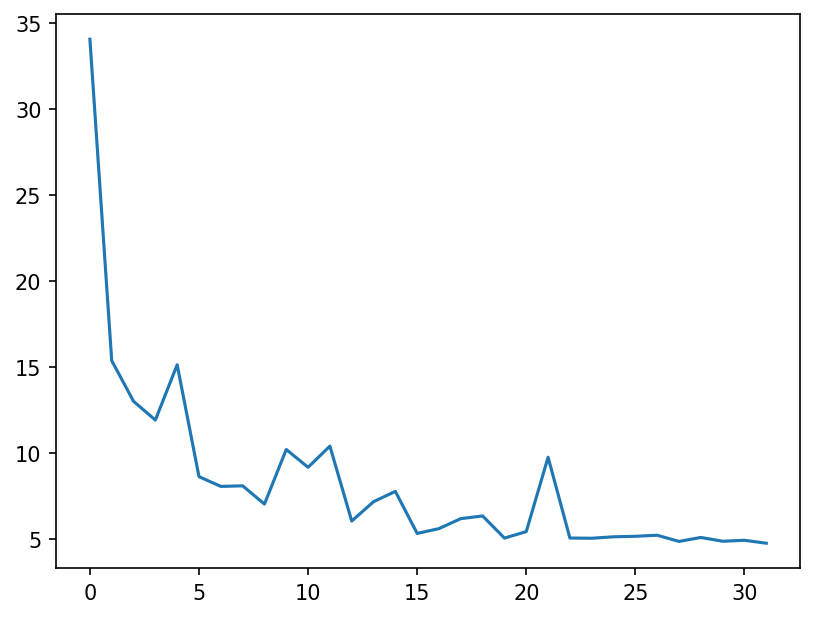

In [15]:
#tot_history = history1_.history['val_loss'] 
tot_history = np.append( history1_.history['val_loss'],history2_.history['val_loss'] )
#tot_history = np.append( tot_history,history3_.history['val_loss'] )

#epochs = np.arange( 0, EPOCHS1 )
epochs = np.arange( 0, EPOCHS1+EPOCHS2 )

plt.plot( epochs, tot_history )
plt.show()


## SWEEPING HYPER-PARAMETERS 

In [6]:
label1 = 'number_of_filters'
label2 = 'kernel_size'

parameters1_arr = np.arange( 20,60,1 )  #-- number of filters
parameters2_arr = np.arange( 20,60,1 )  #-- kernel size
batch_size_size_arr = [64]
pairs = []
for p1 in parameters1_arr:
    for p2 in parameters2_arr:
        pairs.append([p1,p2])
        
training_losses = {}
validation_losses = {}

nb_of_points = len(parameters1_arr)*len(parameters2_arr)
print(label1, parameters1_arr)
print(label2, parameters2_arr)
print(len(parameters1_arr),len(parameters2_arr),nb_of_points)

number_of_filters [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
kernel_size [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
40 40 1600


In [7]:
epochs0=15
epochs=30
best_loss = 1000
worst_loss = -1

t1=time.time()
print('-- nb of points =',nb_of_points )

from datetime import datetime
now = datetime.now()
t_string = now.strftime("%d_%m||%Hh%M")
print("-- t_string", t_string)

if (nb_of_points != len(pairs)):
    print("-- ABORT: parameter sweep already started.")
    sys.exit()


count=0
while pairs:
    
    count +=1
    rand_int = np.random.randint(0, len(pairs))
    pair = pairs[rand_int]
    p1 = int( pair[0] )
    p2 = int( pair[1] )
    pairs.remove(pair)

    print('.',end=' ' )
    
    for bs in batch_size_size_arr:
        
        steps_per_epoch = len(x_train) // bs
        model = get_model( filter_nb=p1, kernel_size=p2, pool_size=2, dropout_rate=0.05 )
        
        opt0 = optimizers.Adam(learning_rate=1e-3)
        model.compile(loss='MAPE', optimizer=opt0)
        history0_ = model.fit( x_train, y_train, bs, epochs=epochs0,\
                         validation_data=(x_test, y_test), verbose=True )
        
        clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-3,
            maximal_learning_rate=1e-5,
            scale_fn=lambda x: 1/(2.**(x-1)),
            step_size=2 * steps_per_epoch)
        opt = optimizers.Adam(clr)
        model.compile(loss='MAPE', optimizer=opt)
        history_ = model.fit( x_train, y_train, bs, epochs=epochs,\
                         validation_data=(x_test, y_test), verbose=True )

        training_losses[ p1 , p2, bs ] = history_.history['loss'][-1]
        validation_losses[ p1 ,p2, bs ] = history_.history['val_loss'][-1]
        if count > 1:
            with open('training/training_losses_'+t_string+'.pkl', 'wb') as f1:
                pickle.dump(training_losses, f1)
            with open('training/validation_losses_'+t_string+'.pkl', 'wb') as f2:
                pickle.dump(validation_losses, f2)

        if (validation_losses[ p1 , p2, bs ] < best_loss):
            model.save('training/best_model_'+t_string, overwrite=True)
            with open('training/best_history_'+t_string+'.pkl', 'wb') as f3:
                pickle.dump( history_.history , f3)
            best_loss = validation_losses[ p1 , p2, bs ]
            best_p1=p1
            best_p2=p2
        
        del model
        del history_
        

t2=time.time()
print(' ')
print('=== COMPLETE ===')
print("-- total time = ", t2-t1)
print("-- best {}, {} =".format(label1, label2), best_p1, best_p2)
print("-- t_string", t_string)


-- nb of points = 1600
-- t_string 02_07||19h57
. Metal device set to: Apple M1


2023-07-02 19:57:49.535741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-02 19:57:49.535954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/15


2023-07-02 19:57:49.822730: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-02 19:57:50.256640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - ETA: 0s - loss: 63.9108

2023-07-02 19:58:11.640449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 23s 47ms/step - loss: 63.9108 - val_loss: 32.6534
Epoch 2/15
470/470 [==============================] - 21s 45ms/step - loss: 22.1640 - val_loss: 14.0177
Epoch 3/15
470/470 [==============================] - 21s 45ms/step - loss: 15.1503 - val_loss: 19.1488
Epoch 4/15
470/470 [==============================] - 21s 45ms/step - loss: 13.2534 - val_loss: 10.2155
Epoch 5/15
470/470 [==============================] - 21s 45ms/step - loss: 11.6085 - val_loss: 11.9352
Epoch 6/15
470/470 [==============================] - 21s 45ms/step - loss: 10.3233 - val_loss: 9.7022
Epoch 7/15
470/470 [==============================] - 21s 45ms/step - loss: 10.5816 - val_loss: 10.1785
Epoch 8/15
470/470 [==============================] - 21s 44ms/step - loss: 9.3932 - val_loss: 7.6645
Epoch 9/15
470/470 [==============================] - 21s 45ms/step - loss: 9.3921 - val_loss: 7.6289
Epoch 10/15
470/470 [==============================] - 21s 44ms/step - loss: 8.9

NameError: name 'steps_per_epoch' is not defined

Best parameters = number_of_filters kernel_size dr = 21 21 64 10.150657653808594


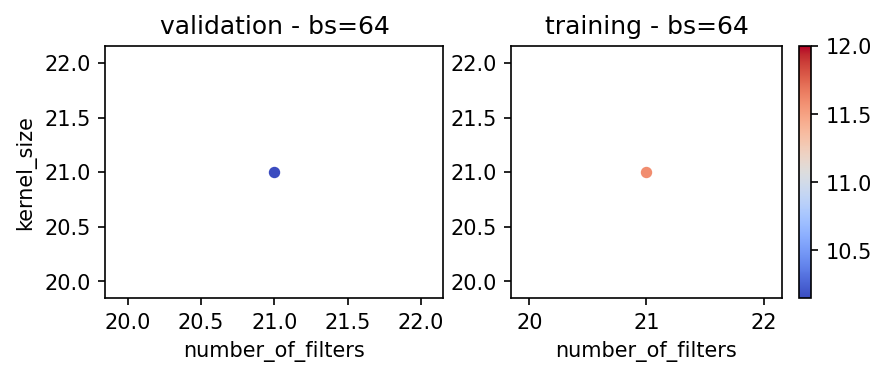

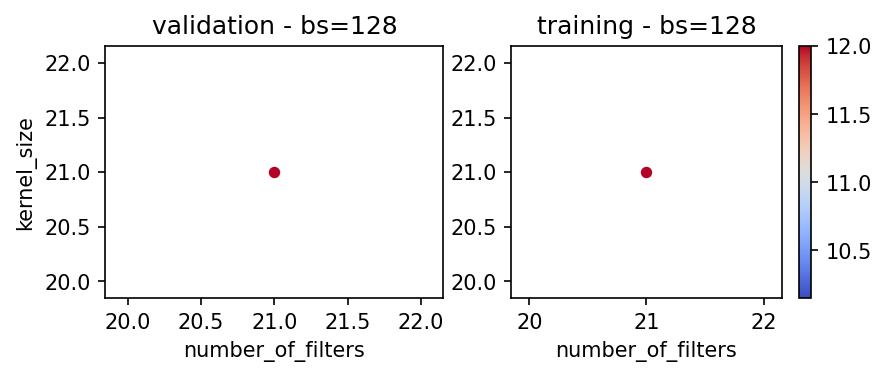

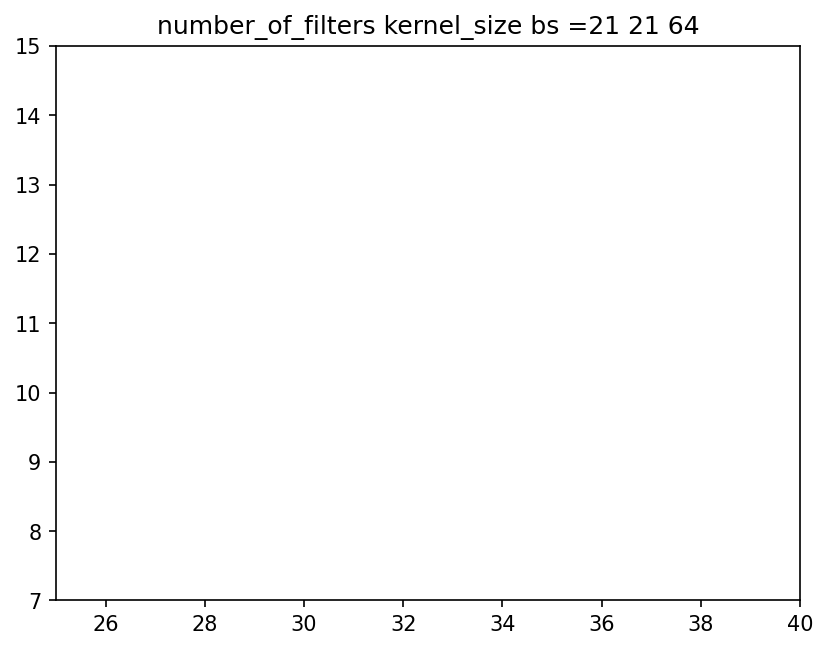

In [106]:
from collections import defaultdict

matplotlib.rcParams['figure.dpi']=150
t_string="02_07||19h42"
with open('training/training_losses_'+t_string+'.pkl', 'rb') as f1:
    training_losses = pickle.load(f1)
with open('training/validation_losses_'+t_string+'.pkl', 'rb') as f2:
    validation_losses = pickle.load(f2)
with open('training/best_history_'+t_string+'.pkl', 'rb') as f3:
    best_history = pickle.load(f3)


min_val = min(validation_losses, key=validation_losses.get)
print( "Best parameters = "+label1+" "+label2+' dr =', min_val[0], min_val[1],min_val[2],validation_losses[min_val] )

#x_scatter = [ x[0] for x in training_losses]
#y_scatter = [ x[1] for x in training_losses]

x_scatter = defaultdict(list)
y_scatter = defaultdict(list)
training_colors = defaultdict(list)
validation_colors = defaultdict(list)
for x in training_losses:
    x_scatter[x[2]].append(x[0])
    y_scatter[x[2]].append(x[1])
    training_colors[x[2]].append( training_losses[x]  )
    validation_colors[x[2]].append( validation_losses[x]  )


#training_colors = [training_losses[x] for x in training_losses]
#validation_colors = [validation_losses[x] for x in training_losses]


for key in x_scatter.keys():
    
    vals = list(validation_losses.values())
    
    plt.subplot(2,2,1)
    mycmap = plt.cm.coolwarm
    lognorm=matplotlib.colors.LogNorm()
    #plt.scatter( x_scatter, y_scatter, s=20, c=validation_colors, cmap=mycmap)#,norm=lognorm )
    plt.scatter( x_scatter[key], y_scatter[key], s=20, c=validation_colors[key], cmap=mycmap)#,norm=lognorm )
    plt.xlabel(label1)
    plt.ylabel(label2)
    #plt.clim( min(vals), max(vals) )
    plt.clim( min(vals), 12 )
    plt.title( 'validation - bs='+str(key) )

    plt.subplot(2,2,2)
    lognorm=matplotlib.colors.LogNorm()
    mycmap = plt.cm.coolwarm
    plt.scatter( x_scatter[key], y_scatter[key], s=20, c=training_colors[key], cmap=mycmap)#,norm=lognorm )
    plt.xlabel(label1)
    plt.title( 'training - bs='+str(key) )
    plt.clim( min(vals), 12 )
    #plt.clim( min(vals), max(vals) )
    plt.colorbar()
    
    plt.show()

plt.scatter( np.arange(len(best_history['val_loss'])), best_history['val_loss'], s=5 )
plt.plot( np.arange(len(best_history['loss'])), best_history['loss'], dashes=[2,2,2,2] )
plt.savefig('training/plots/'+t_string+'.pdf',format='pdf')
plt.title( label1+" "+label2+' bs ='+str(min_val[0])+" "+str(min_val[1])+" "+str(min_val[2]) )
plt.xlim(25,40)
plt.ylim(7,15)
plt.show()

##  MODEL TESTING

In [16]:
reconstructed_model = models.load_model("training/CNN_1_FULL_LAYERS_LASTEST_fil=80", compile=False)

In [18]:
probability_model = tf.keras.Sequential([reconstructed_model])
#probability_model = tf.keras.Sequential([model])
predictions_best = probability_model.predict(x_test)

  1/166 [..............................] - ETA: 45s

2023-07-03 13:08:27.494532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


166/166 [==============================] - 2s 11ms/step


(0.0, 500000.0)

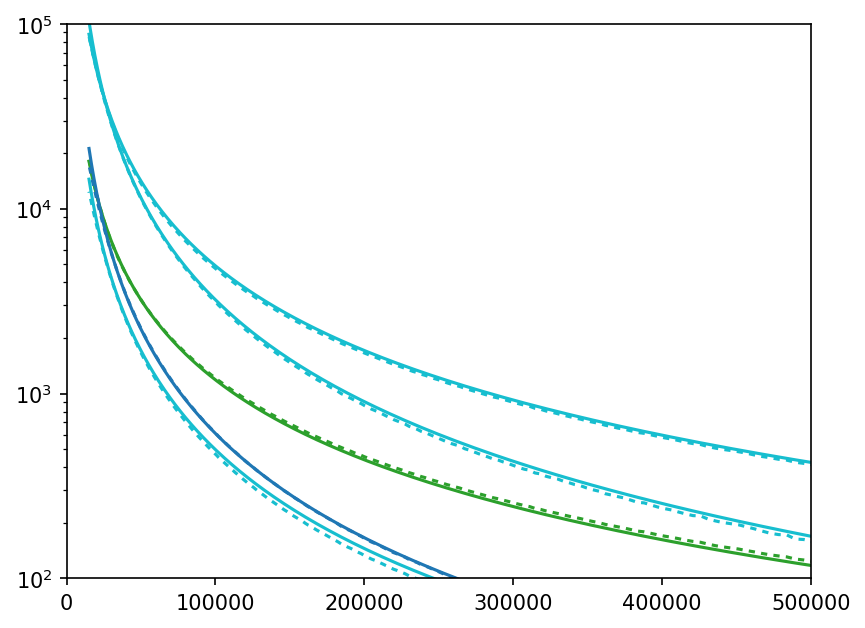

In [25]:
plt.subplot(1, 1, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(5,) )
for i in rand_set:
    plt.plot(w_train, y_test[i,:],color='C'+str(i))
    plt.plot(w_train, predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')
plt.ylim(1e2,1e5)
plt.xlim(0, 0.5e6)

In [ ]:
matplotlib.rcParams['figure.dpi']=300
plt.subplot(1, 2, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(30,) )
for i in rand_set:
    plt.plot(w0,y_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')

plt.subplot(1, 2, 2)
for i in rand_set:
    plt.plot( x_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))